In [1]:
## Environment: conda env:tf212gpu
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_retrain, plot_results
from exp_hp import get_hp

2024-08-30 15:13:46.462554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 15:13:46.804364: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  0


In [3]:
#%% >>>>> Plot Accuracy & Loss during Training >>>>>
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([])

def plot_results(n_epochs, epoch, patience, loss, loss_val, acc, acc_val, showplot=True):
    trainColor = 'k'
    valColor = (141/255,171/255,127/255,1.)
    FS = 14
    plt.figure(figsize=(15, 7))

    #---------- plot loss -------------------
    ax = plt.subplot(2,2,1)
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
    ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)

    plt.plot(acc, 'o', color=trainColor, label='Training',alpha=0.6)
    plt.plot(acc_val, 'o', color=valColor, label='Validation',alpha=0.6)
    plt.vlines((epoch+1)-patience,-10,1,'k',linestyle='dashed',alpha=0.4)

    plt.title('ACCURACY')
    plt.xlabel('EPOCH')
    plt.xticks(np.arange(0,120,20),labels=np.arange(0,120,20))
    plt.yticks(np.arange(.4,1.1,.1),labels=[0.4,0.5,0.6,0.7,0.8,0.9,1.0]) # 0,0.1,0.2,0.3,
    plt.grid(True)
    plt.legend(frameon=True, fontsize=FS)
    plt.xlim(-2, 100)
    plt.ylim(.4,1)
    
    # ---------- plot accuracy -------------------
    ax = plt.subplot(2,2,2)
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
    ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)
    
    plt.plot(loss, 'o', color=trainColor, label='Training',alpha=0.6)
    plt.plot(loss_val, 'o', color=valColor, label='Validation',alpha=0.6)
    plt.vlines((epoch+1)-patience,0,1,'k',linestyle='dashed',alpha=0.4)
    plt.title('PREDICTION LOSS')
    plt.xlabel('EPOCH')
    plt.legend(frameon=True, fontsize=FS)
    plt.xticks(np.arange(0, 120,20),labels=np.arange(0, 120,20))
    plt.yticks(np.arange(0,1.1,.1),labels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    plt.ylim(0,1)
    plt.grid(True)
    plt.xlim(-2, 100)

    # ---------- Make the plot -------------------
    #plt.tight_layout()
    if showplot==False:
        plt.close('all')
    else:
        plt.show()

### Fuctions

In [4]:
def create_ann2(input_shape,output_shape, hiddens, RIDGE = 0, dropout = True, dropout_rate = 0.0):
    tf.keras.backend.clear_session() 

    # ----- input of cnn -----
    ann_input = keras.Input(shape = input_shape)

    for l,layer in enumerate(hiddens):
        # ----- ann layers -----
        if l == 0:
            x = tf.keras.layers.Dense(layer, 
                                      activation = 'relu',
                                      use_bias = True, 
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=RIDGE),
                                      bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(ann_input)
            if dropout:
                x = layers.Dropout(rate = dropout_rate)(x)
        else:
            x = tf.keras.layers.Dense(layer, 
                                      activation = 'relu',
                                      use_bias = True, 
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                      bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
        
    # ----- output -----
    ann_output = tf.keras.layers.Dense(output_shape,
                                       activation = tf.keras.activations.softmax,
                                       use_bias = True,
                                       kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                       bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                       kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
    # ----- create unet -----
    ann = keras.Model(ann_input, ann_output, name = 'ann')
    
    return ann

In [5]:
def custom_lr_scheduler(epoch, lr):
    if epoch == 3: #(epoch > 0) and (epoch % 5 == 0):
        return lr * 0.01 
    else:
        return lr

In [6]:
EXP_NAME2 = 'exp2_retrain'
hps2 = get_hp(EXP_NAME2)
EXP_NAME = 'exp2'
hps = get_hp(EXP_NAME)

print('Training Members: '+str(hps2['train_mems']))
print('Validation Member: '+str(hps2['val_mems'][0]))
print('Testing Member: '+str(hps2['test_mems'][0]))
print('Lead: '+str(hps2['LEAD']))
print('Region: '+str(hps2['region'][0])+'N x '+str(hps2['region'][1])+'E')

X2train, X2val, _, Y2train, Y2val, _, _ = split_retrain(trainmems = hps2['train_mems'],
                                                          valmem = hps2['val_mems'][0],
                                                          testmem = hps2['test_mems'][0],
                                                          months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                          lead = hps2['LEAD']) # 330 or 210

X2val = X2val.reshape((X2val.shape[0],X2val.shape[1]*X2val.shape[2]))
X2train = X2train.reshape((X2train.shape[0],X2train.shape[1]*X2train.shape[2]))
input_shape = X2train.shape[1]

Training Members: ['0201', '0211', '0221', '0231', '0241', '0251', '0261', '0271', '0281']
Validation Member: 0291
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
loading data & saving


In [14]:
hps = get_hp(EXP_NAME) # need to have this here because .extend overwrites HIDDENS

HIDDENS = [128] #hps['HIDDENS']
# HIDDENS.extend(hps2['ADD_HIDDENS'])
GLOBAL_SEED = hps['GLOBAL_SEED']

ann2LR_INIT = 0.25 #hps2['LR_INIT'] 
ann2BATCH_SIZE = 512 #hps2['BATCH_SIZE'] 
ann2dropout_rate = 0.3#0.7 #hps2['DROPOUT_RATE'] 
dropout_bool = True
ann2RIDGE = hps2['RIDGE'] 
PATIENCE = 30 #hps2['PATIENCE']

# Create a dataset
dataset = tf.data.Dataset.from_tensor_slices((X2train, Y2train)).shuffle(buffer_size=Y2train.shape[0]).batch(ann2BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X2val, Y2val)).batch(ann2BATCH_SIZE)

0
Early stopping at epoch 53


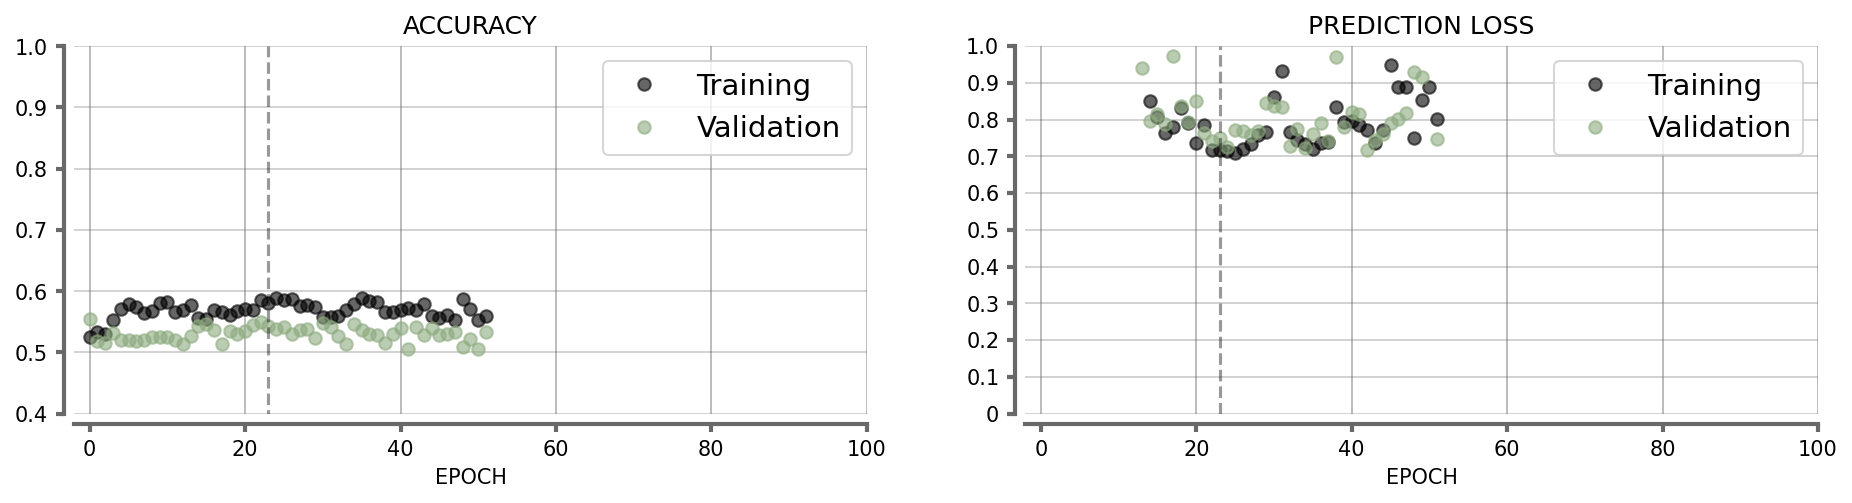

243/243 [==============================] - 0s 1ms/step
55.07731958762887
54.884020618556704
CPU times: user 30.1 s, sys: 152 ms, total: 30.2 s
Wall time: 52.3 s


In [15]:
%%time
# ---------- ANN Hyperparameters ----------
NLABEL = 2
N_EPOCHS = 1000

#----- SET UP & TRAIN NN -----
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)
    
for SEED in range(1):
    print(SEED)
    tf.keras.backend.clear_session() 
    wait = 0
    best_val_loss = float('inf')
    best_weights = None
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate = ann2LR_INIT)
    
    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    train_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
    val_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
    
    #@tf.function
    def train_step(X, y):
        with tf.GradientTape() as tape:
            predictions = model(X, training=True)
            loss = loss_fn(y, predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        train_acc_metric.update_state(y, predictions)
        train_loss_metric.update_state(y, predictions)
        return loss
        
    #@tf.function    
    def val_step(X, y):
        val_predictions = model(X, training=False)
        val_loss = loss_fn(y, val_predictions)
        val_acc_metric.update_state(y, val_predictions)
        val_loss_metric.update_state(y, val_predictions)
        return val_loss
    
    # ------ define NN ------
    model = create_ann2(input_shape = input_shape,
                       output_shape = NLABEL,
                       hiddens=HIDDENS,
                       RIDGE = ann2RIDGE,
                       dropout = dropout_bool, dropout_rate = ann2dropout_rate)

    annfi_name = 'ann_60Eshift_check_seed'+str(SEED)+'.h5'
    ann1 = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)
    model.layers[1].set_weights(ann1.layers[1].get_weights())

    LOSS_LIST = []
    LOSS_VAL_LIST = []
    ACC_LIST  = []
    ACC_VAL_LIST  = []
    
    for epoch in range(N_EPOCHS):  # Number of epochs
        # print(f"Epoch {epoch + 1}")
        step = 0
        lr = custom_lr_scheduler(epoch, optimizer.lr.numpy())
        optimizer.learning_rate.assign(lr)
    
        for batch_X, batch_y in dataset:
            loss = train_step(batch_X, batch_y)
            step += 1
            if step >= len(dataset) // 10:  # Stop after processing 1/6 of the batches
                break
        
        for batch_X_val, batch_y_val in val_dataset:
            val_loss = val_step(batch_X_val, batch_y_val)
    
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.get_weights()  # Save the best weights
            wait = 0  # Reset patience counter
        else:
            wait += 1
            if wait >= PATIENCE:
                print(f"Early stopping at epoch {epoch + 1}")
                model.set_weights(best_weights)  # Restore the best weights
                break

        ACC_LIST.append(float(train_acc_metric.result()))
        ACC_VAL_LIST.append(float(val_acc_metric.result()))
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        LOSS_LIST.append(float(train_loss_metric.result()))
        LOSS_VAL_LIST.append(float(val_loss_metric.result()))
        train_loss_metric.reset_states()
        val_loss_metric.reset_states()
        
    plot_results(N_EPOCHS, epoch, PATIENCE, LOSS_LIST, LOSS_VAL_LIST, ACC_LIST, ACC_VAL_LIST)

    pred1 = np.argmax(ann1.predict(X2val),axis=-1)
    pred2 = np.argmax(model.predict(X2val),axis=-1)

    print((np.shape(np.where(pred1==Y2val)[0])[0]/np.shape(Y2val)[0])*100) # og network 
    print((np.shape(np.where(pred2==Y2val)[0])[0]/np.shape(Y2val)[0])*100) # first layer weights transferred 

    # model.compile(optimizer=optimizer, loss=loss_fn, metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), tf.keras.metrics.SparseCategoricalAccuracy()])
    # annfi_name = 'ann2_60Eshift_check_seed'+str(SEED)+'.h5'
    # model.save(base_dir+'train/saved_models/'+annfi_name)